In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import copy
import emcee
from scipy.optimize import curve_fit
from math import inf

In [2]:
df_0307 = pd.read_csv('250307_fitc_counts_splntrue.csv',index_col=0)
df_1215 = pd.read_csv('../Cre_lox_FACS_2023/bEG36/221215_fitc_counts_splntrue.csv',index_col=0)
df_0202 = pd.read_csv('../Cre_lox_FACS_2023/bEG57/230202_fitc_counts_splntrue.csv',index_col=0)

df_all = pd.concat((df_0307,df_1215))
df_all = pd.concat((df_all,df_0202))

# if some files literally contain the string "NaN", turn those into real NaN first
df_all['technical_replicate'] = df_all['technical_replicate'].replace('NaN', np.nan)

# compare using a numeric view (non-numeric -> NaN)
tr = pd.to_numeric(df_all['technical_replicate'], errors='coerce')

# keep tr <= 3 OR tr is NaN - limits to three technical replicates per experiment
df_all = df_all[(tr <= 3) | (tr.isna())].copy()

random.seed(42)

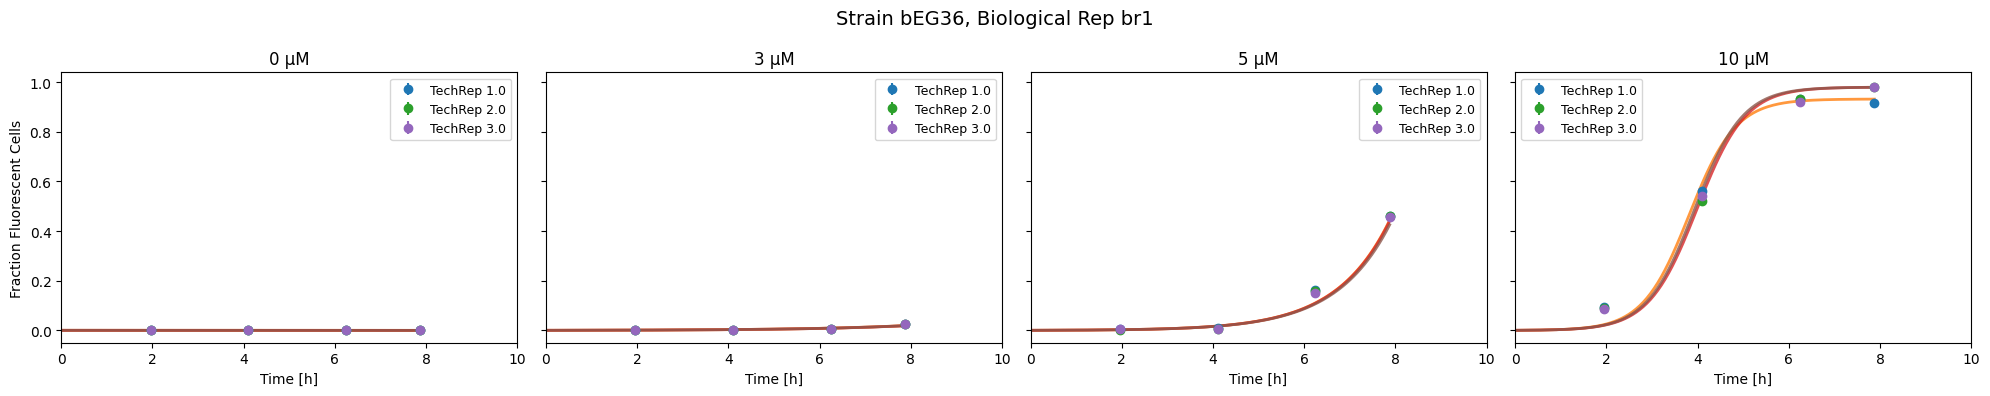

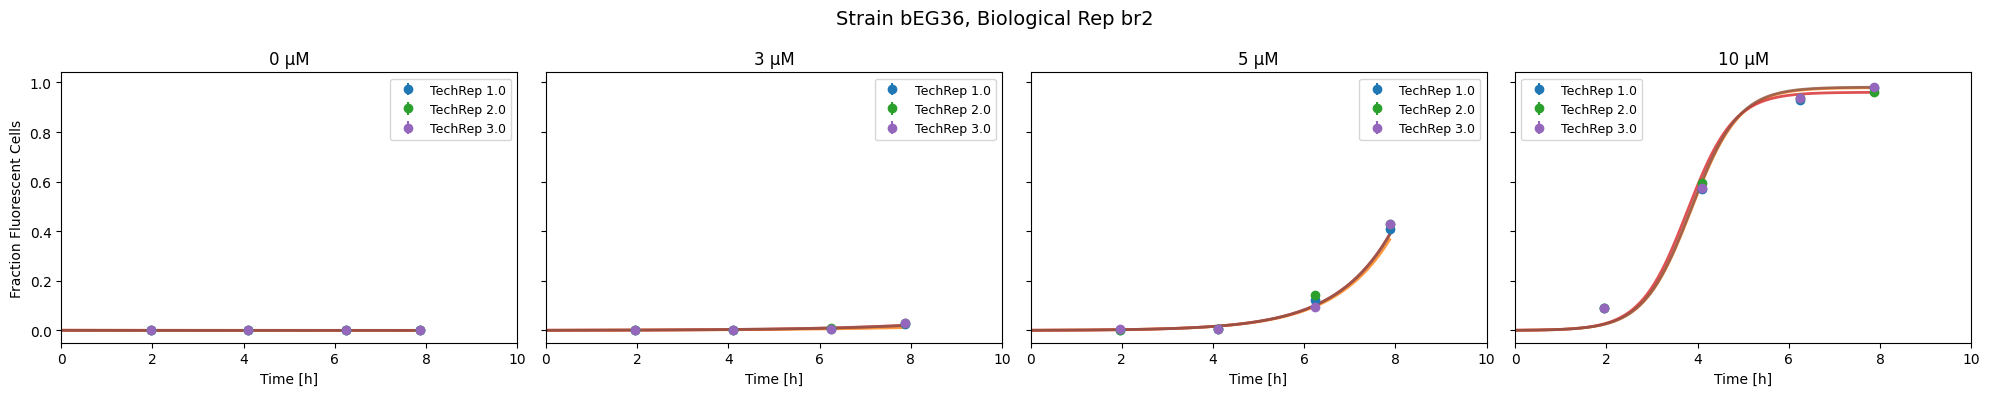

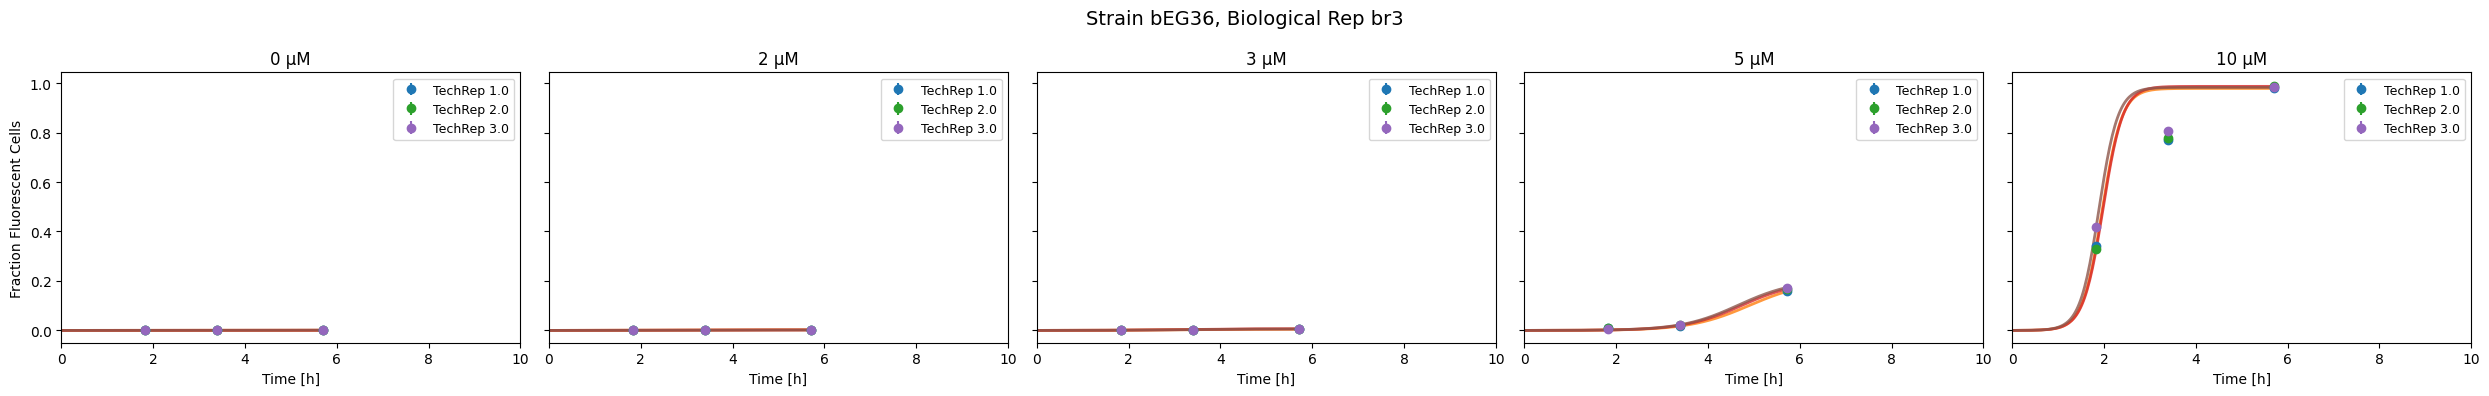

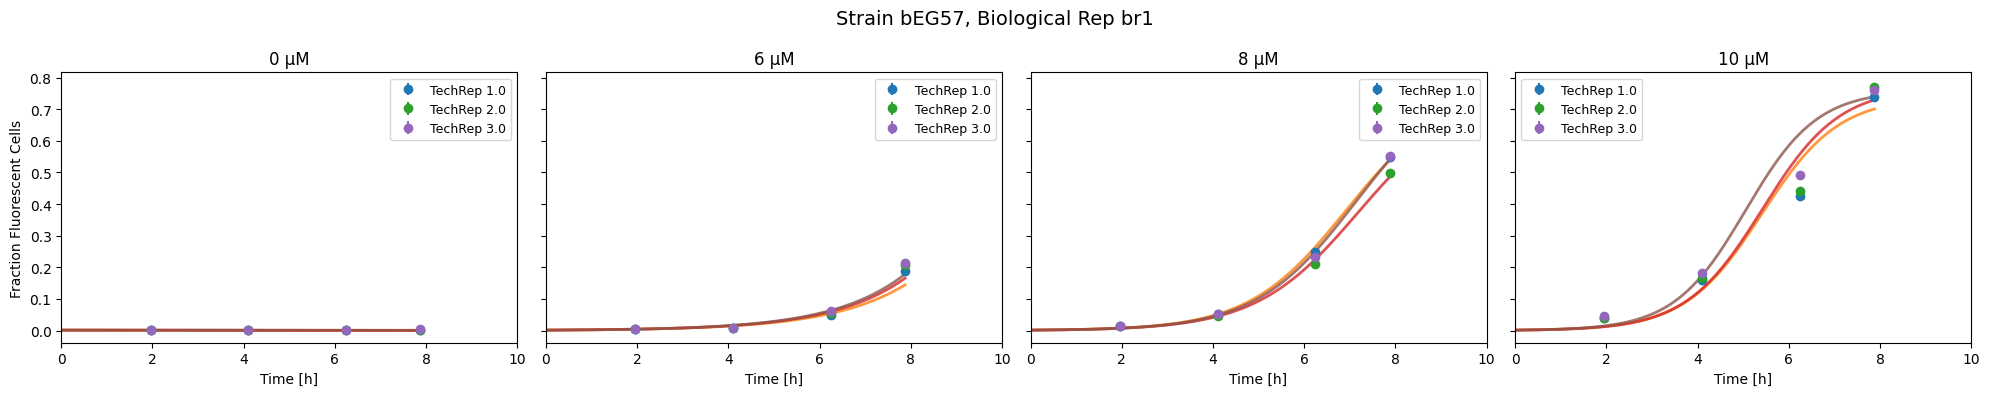

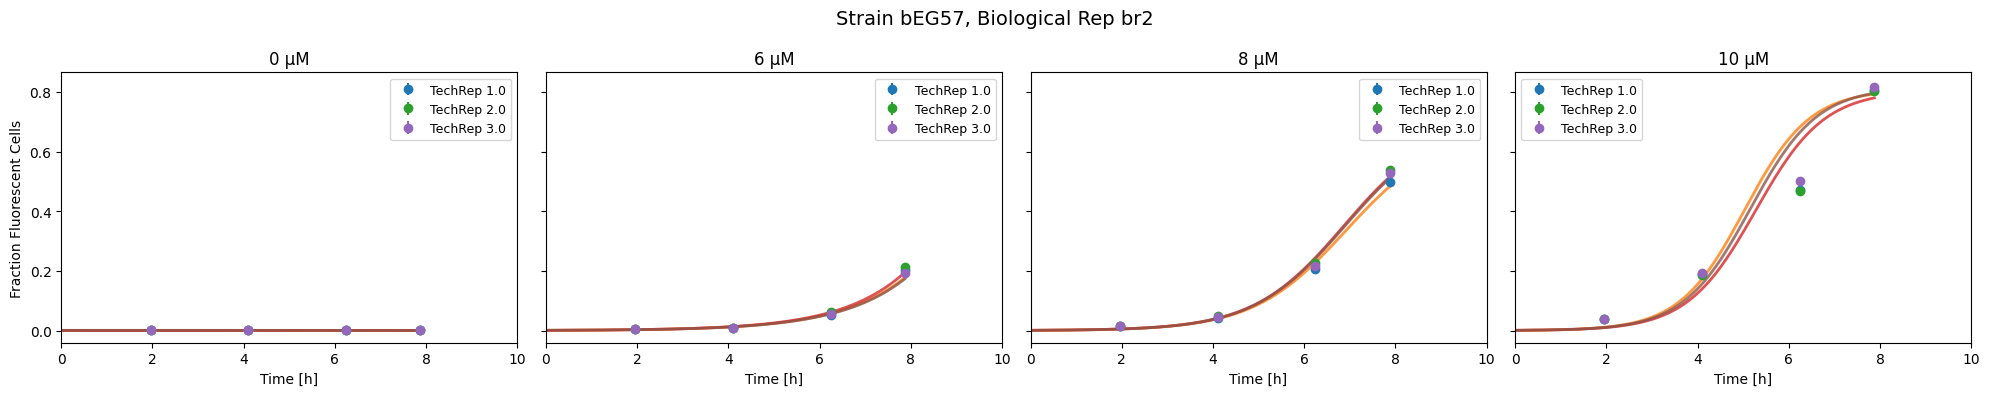

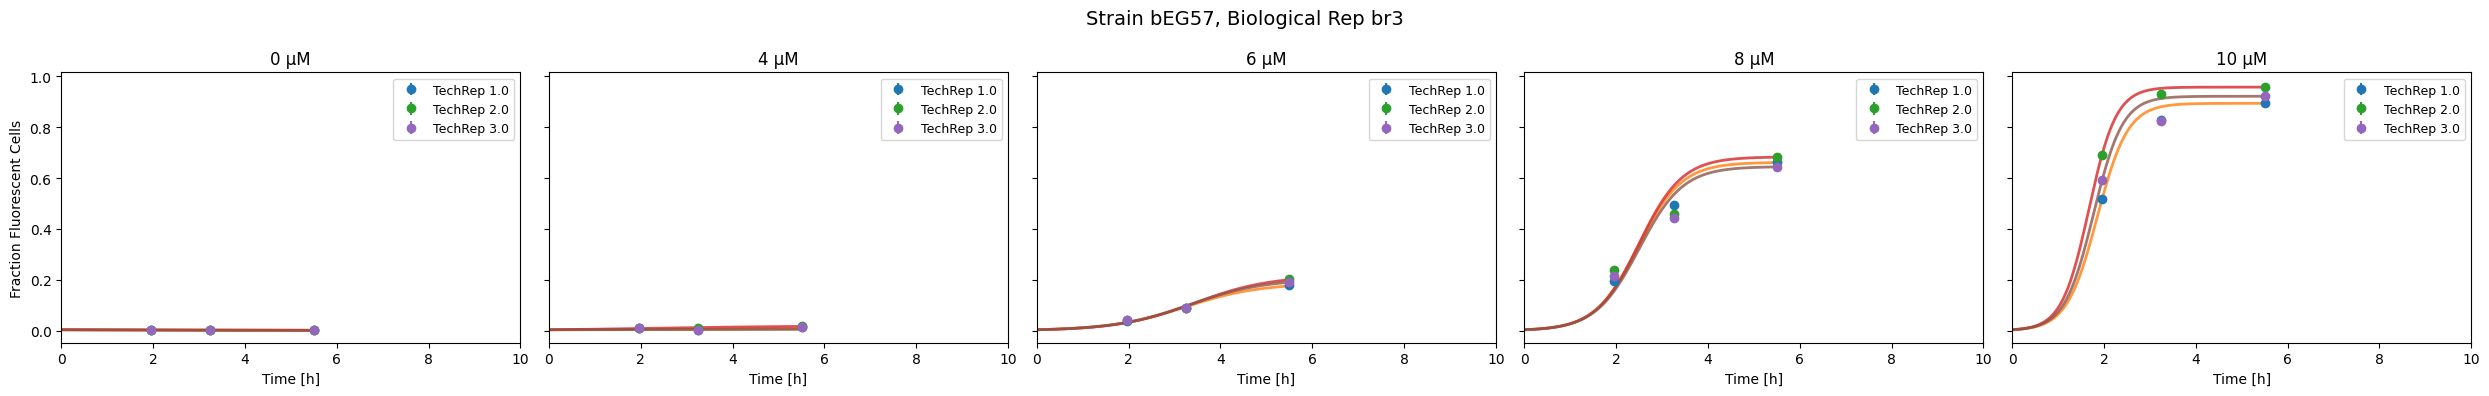

In [3]:
# This script runs Bayesian MCMC fits (full logistic model) and non-linear fits (exponential)
# on fluorescence time-series data for multiple biological and three technical replicates, with
# time capped at 10 hours. It then plots results per replicate and aggregates them into a boxplot.

# ---------- Config: cap analysis/plots at 10 hours ----------
MAX_HOURS = 10.0
MAX_MIN = int(60 * MAX_HOURS)

# ---------- Models ----------
def full_model(t, fmax, k, f0):
    """Full nonlinear logistic model."""
    return fmax / (1 + (fmax / f0 - 1) * np.exp(-k * t))

def exp_model(t, k, f0):
    """Simple exponential growth model with fixed f0."""
    return f0 * np.exp(k * t)

# ---------- Log-likelihood & Priors ----------
def log_likelihood(theta, t, y, yerr, f0):
    """Computes the Gaussian log-likelihood for given parameters (fmax, k).
    Rejects invalid parameters (fmax ≤ 0, fmax > 1, or k ≤ −1) by returning -inf.
    Uses squared residuals normalized by measurement errors yerr."""
    fmax, k = theta
    # Constrain to valid parameter space - constrains k to be larger than -1/h
    if fmax <= 0 or fmax > 1 or k <= -1:
        return -np.inf
    model_vals = full_model(t, fmax, k, f0)
    return -0.5 * np.sum(((y - model_vals) / yerr)**2 + np.log(2*np.pi*yerr**2))

def log_prior(theta, fobs_max):
    """Defines flat (uninformative) priors with hard bounds:
    fmax between the observed max fraction and 1.0
    k between −1 and 5
    Outside bounds → -inf (zero probability)."""
    fmax, k = theta
    # fmax between observed max and 1.0; k between -1 and 5 - note that this constrains the posterior too because
    # posterior log likelihood = log likelihood + log prior + constant.
    if fobs_max <= fmax <= 1.0 and -1 <= k <= 5:
        return 0.0 # uninformative prior
    return -np.inf

def log_posterior(theta, t, y, yerr, f0, fobs_max):
    """Returns log posterior = log prior + log likelihood.
    Immediately rejects if prior is -inf."""
    lp = log_prior(theta, fobs_max)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr, f0)

# ---------- Main Analysis ----------
replicate_level_mcmc_results = [] # list of per-replicate fit results (for later aggregation).
mcmc_samples_dict = {} # dictionary mapping (strain, bio_rep, tech_rep, conc) to raw MCMC samples.

# Extracts the list of unique strains and biological replicate IDs.
unique_strains = df_all['strain_name'].unique()
bio_replicates = df_all['biological_replicate'].unique()

# Loop over each strain, subsetting the dataframe to that strain’s data.
for strain in unique_strains:
    strain_df = df_all[df_all['strain_name'] == strain]

    # For each biological replicate, subset data; skip if none present.
    for br in bio_replicates:
        br_df = strain_df[strain_df['biological_replicate'] == br]
        if br_df.empty:
            continue
        
        # Baseline f0 (t = 0 only; unaffected by time cap)
        f0_values = br_df[br_df['time_point [min]'] == 0]['fraction_fluorescent_cells'].values
        if len(f0_values) == 0:
            continue
        f0 = f0_values[0] # takes initial frequency (same for all treatments and technical replicates)

        tech_replicates = br_df['technical_replicate'].unique()

        # --- Concentrations per bio replicate ---
        concentrations = sorted(br_df['Inducer_concentration [uM]'].dropna().unique())
        if len(concentrations) == 0:
            continue

        # Create subplots: one column per concentration, shared y-axis.
        ncols = len(concentrations)
        fig, axes = plt.subplots(1, ncols, figsize=(5*ncols, 4), sharey=True)
        if ncols == 1:
            axes = [axes]
        fig.suptitle(f"Strain {strain}, Biological Rep {br}", fontsize=14)

        # Loop through each inducer concentration, subset the data, and select the subplot axis.
        for i, conc in enumerate(concentrations):
            ax = axes[i]
            # filter dataframe to only keep the current inducer concentration
            conc_df = br_df[br_df['Inducer_concentration [uM]'] == conc]

            # --- Loop over technical replicates ---
            for tr in tech_replicates[1:]: # skips time point 0 with no tech replicate
                tr_df = conc_df[conc_df['technical_replicate'] == tr]

                # >>> Cap data at 10h <<<
                tr_df = tr_df[tr_df['time_point [min]'] <= MAX_MIN]
                if len(tr_df) < 2: # Skip if fewer than two time points remain.
                    continue

                # --- Prepare data (hours) ---
                tdata = tr_df['time_point [min]'].values / 60.0
                ydata = tr_df['fraction_fluorescent_cells'].values
                yerr  = tr_df['error'].values
                if len(ydata) == 0:
                    continue

                # Get the maximum observed fraction fluorescent (used in prior)
                fobs_max = ydata.max()

                # times for fit
                t_fit_end = min(MAX_HOURS, float(tdata.max()) * 1.0)
                if t_fit_end <= 0:
                    continue
                t_fit = np.linspace(0, t_fit_end, 200)

                if conc > 0.5: # exclude concentrations equal to 0
                    # --- Logistic model: MCMC ---
                    ndim, nwalkers = 2, 48 # 2 parameters, 48 walkers
                    # Initial parameters drawn uniformly in allowed ranges
                    fmax_init = np.random.uniform(low=fobs_max, high=1.0, size=(nwalkers, 1))
                    # k_init = np.random.uniform(low=0.0, high=1.5, size=(nwalkers, 1))
                    k_init = np.random.uniform(low=-1.0, high=5, size=(nwalkers, 1))
                    pos = np.hstack([fmax_init, k_init])
    
                    """ Create an emcee sampler for the log posterior.
                    Run 10,000 steps; discard first 4,000 as burn-in.
                    Flatten the chain to get all samples, store in dictionary."""
                    sampler = emcee.EnsembleSampler(
                        nwalkers, ndim, log_posterior, args=(tdata, ydata, yerr, f0, fobs_max)
                    )
                    sampler.run_mcmc(pos, 10000, progress=False)
                    samples = sampler.get_chain(discard=5000, flat=True)
                    mcmc_samples_dict[(strain, br, tr, conc)] = samples
    
                    # === Choose the highest-likelihood logistic params from the chain (fair AIC) ===
                    # Since your prior is flat (0) within bounds and -inf outside, maximizing the
                    # posterior log-prob is equivalent to maximizing the log-likelihood.
                    log_probs = sampler.get_log_prob(discard=5000, flat=True)  # shape (n_samples,)
                    best_idx = np.argmax(log_probs)
                    fmax_mle, k_mle = samples[best_idx]  # "MLE/MAP" within prior bounds
                    
                    # --- Best-fit curve & CI (capped at 10h) ---
                    # Computes the max likelihood curve. This is the solid line plotted below
                    y_fit_full = full_model(t_fit, fmax_mle, k_mle, f0)
                    
                    # Randomly selects up to 200 draws from posterior samples (without replacement) to draw CIs.
                    idx = np.random.choice(samples.shape[0], min(200, samples.shape[0]), replace=False)
                    y_posterior = np.array([full_model(t_fit, s[0], s[1], f0) for s in samples[idx]])
                    # y_lower_full = np.percentile(y_posterior, 2.5, axis=0)
                    # y_upper_full = np.percentile(y_posterior, 97.5, axis=0)
                    
                    # Compute log-likelihood at that best point
                    logL_full = log_likelihood([fmax_mle, k_mle], tdata, ydata, yerr, f0)
                    
                    # AIC / AICc for logistic (kparams_full = 2: fmax, k)
                    kparams_full = 2
                    npts = len(ydata)
                    AIC_full = 2 * kparams_full - 2 * logL_full
                    AICc_full = (
                        AIC_full + (2 * kparams_full * (kparams_full + 1)) / (npts - kparams_full - 1)
                        if (npts - kparams_full - 1) > 0 else AIC_full
                    )
                else: # if conc is zero, only fit exponential model
                    logL_full = np.inf
                    AIC_full = np.inf
                    AICc_full = np.inf
                    fmax_mle = np.inf
                    k_mle = np.inf

                # --- Exponential model: non-linear fit with multiple starting points ---
                k_starts = np.linspace(-1.0, 3.0, 10)
                
                best = {
                    'k': None,
                    'pcov': None,
                    'logL': -inf,
                    'ssr': inf
                }
                
                for k0 in k_starts:
                    try:
                        popt, pcov = curve_fit(
                            lambda t, k: exp_model(t, k, f0),
                            tdata, ydata,
                            sigma=yerr, absolute_sigma=True,
                            p0=[k0],
                            bounds=(-1.0, 5.0),   # or use bounds=(-1, 5) to enforce your prior range
                            maxfev=20000                # more iterations just in case
                        )
                        k_fit = popt[0]
                
                        # evaluate weighted residuals and log-likelihood for selection
                        resid = ydata - exp_model(tdata, k_fit, f0)
                        # this is the chi-square term (sum of squared standardized residuals)
                        chi2 = np.sum((resid / yerr)**2)
                        # log-likelihood under Gaussian errors (constant terms included for clarity)
                        logL = -0.5 * np.sum((resid / yerr)**2 + np.log(2*np.pi*yerr**2))
                
                        # keep the best (max logL / min chi2)
                        if logL > best['logL']:
                            best.update({'k': k_fit, 'pcov': pcov, 'logL': logL, 'ssr': chi2})
                
                    except Exception:
                        # some starts might fail to converge; just skip them
                        continue
                
                # final pick
                if best['k'] is None:
                    raise RuntimeError("Exponential multi-start fits failed to converge.")
                k_exp_fit = best['k']
                k_exp_err = (np.sqrt(np.diag(best['pcov']))[0]
                             if best['pcov'] is not None and np.isfinite(best['pcov'][0,0])
                             else np.nan)
                y_fit_exp = exp_model(t_fit, k_exp_fit, f0)

                # --- Exponential: logL, AIC, AICc (linear-space errors) ---
                residuals_exp = ydata - exp_model(tdata, k_exp_fit, f0)
                logL_exp = -0.5 * np.sum((residuals_exp / yerr)**2 + np.log(2*np.pi*yerr**2))
                kparams_exp = 1
                npts = len(ydata)
                # Computes AIC
                AIC_exp = 2*kparams_exp - 2*logL_exp
                # Computes corrected AIC
                AICc_exp = AIC_exp + (2*kparams_exp*(kparams_exp+1)) / (npts - kparams_exp - 1) if (npts - kparams_exp - 1) > 0 else AIC_exp

                # --- Plot each technical replicate ---
                ax.errorbar(tdata, ydata, yerr=yerr, fmt='o', label=f'TechRep {tr}')
                if AICc_full < AICc_exp:
                    ax.plot(t_fit, y_fit_full, lw=2, alpha=0.8)
                else:
                    ax.plot(t_fit, y_fit_exp, lw=2, alpha=0.8)

                # --- Store replicate-level results ---
                # Select best model based on lowest AIC
                best_model = "full" if AICc_full < AICc_exp else "exponential"
                k_best = k_mle if best_model == "full" else k_exp_fit

                replicate_level_mcmc_results.append({
                    'strain': strain,
                    'biological_replicate': br,
                    'technical_replicate': tr,
                    'concentration': conc,
                    'f0': f0,
                    'fmax_mcmc': fmax_mle,
                    'k_mcmc': k_mle,
                    'k_exponential': k_exp_fit,
                    'AIC_full': AIC_full,
                    'AIC_exponential': AIC_exp,
                    'AICc_full': AICc_full,
                    'AICc_exponential': AICc_exp,
                    'best_model': best_model,
                    'k_best': k_best
                })

            # Finish subplot formatting
            ax.set_xlim(0, MAX_HOURS)  # cap x-axis at 10h
            ax.set_xlabel('Time [h]')
            ax.set_title(f'{conc} μM')
            if i == 0:
                ax.set_ylabel('Fraction Fluorescent Cells')
            ax.legend(fontsize=9)

        plt.tight_layout()
        plt.show()

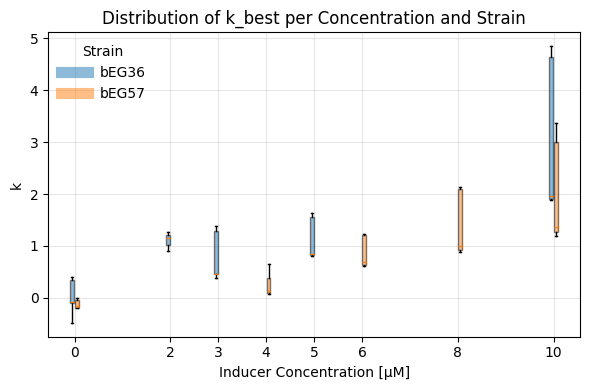

strain  concentration  n_reps  k (mean ± SEM)        95% CI (t)
 bEG36              0       9 -0.0578 ± 0.137   [-0.374, 0.258]
 bEG36              2       3      1.1 ± 0.11     [0.632, 1.58]
 bEG36              3       9   0.734 ± 0.148     [0.393, 1.08]
 bEG36              5       9    1.09 ± 0.127     [0.795, 1.38]
 bEG36             10       9    2.85 ± 0.466      [1.78, 3.93]
 bEG57              0       9 -0.116 ± 0.0284 [-0.182, -0.0505]
 bEG57              4       3   0.284 ± 0.182    [-0.497, 1.07]
 bEG57              6       9  0.848 ± 0.0945     [0.631, 1.07]
 bEG57              8       9    1.34 ± 0.195     [0.892, 1.79]
 bEG57             10       9    1.92 ± 0.317      [1.19, 2.65]
strain biological_replicate  concentration  n_reps    k (mean ± SD)
 bEG36                  br1              0       3 -0.0776 ± 0.0275
 bEG36                  br1              3       3   0.455 ± 0.0022
 bEG36                  br1              5       3  0.851 ± 0.00293
 bEG36                  

In [4]:
# Convert the list of per-replicate results into a pandas DataFrame
replicate_level_df = pd.DataFrame(replicate_level_mcmc_results)

# Ensure concentration is numeric if needed (comment out if already numeric)
# replicate_level_df['concentration'] = pd.to_numeric(replicate_level_df['concentration'])

# ---------- Aggregate per strain & concentration ----------
agg_results = (
    replicate_level_df
    .groupby(['strain', 'concentration'], dropna=False)
    .agg(
        k_mean = ('k_best', 'mean'),   # mean of k_best values across replicates
        k_std  = ('k_best', 'std'),    # standard deviation of k_best across replicates
        n_reps = ('k_best', 'count')   # number of replicate fits contributing
    )
    .reset_index()
)

# Standard error of the mean
agg_results['k_sem'] = agg_results['k_std'] / np.sqrt(agg_results['n_reps'])

# 95% CI using normal approx (use t for small n below)
agg_results['k_lo95_norm'] = agg_results['k_mean'] - 1.96 * agg_results['k_sem']
agg_results['k_hi95_norm'] = agg_results['k_mean'] + 1.96 * agg_results['k_sem']

# 95% CI using t critical (better for small n)
# if you don't have scipy, skip this block or precompute a small lookup
try:
    from scipy.stats import t
    # degrees of freedom = n-1; clip at 1 to avoid invalid
    df = agg_results['n_reps'].clip(lower=1) - 1
    tcrit = t.ppf(0.975, df)
    agg_results['k_lo95_t'] = agg_results['k_mean'] - tcrit * agg_results['k_sem']
    agg_results['k_hi95_t'] = agg_results['k_mean'] + tcrit * agg_results['k_sem']
except Exception:
    agg_results['k_lo95_t'] = agg_results['k_lo95_norm']
    agg_results['k_hi95_t'] = agg_results['k_hi95_norm']

# ---------- Boxplot (medians/IQR) ----------
plt.figure(figsize=(6,4))

# We’ll create proxy handles so the legend shows strains
handles = []
labels = []

for i, (strain, sub_df) in enumerate(replicate_level_df.groupby('strain')):
    concentrations = sorted(sub_df['concentration'].unique())
    # small horizontal offset per strain to avoid overlap
    positions = [c + i*0.1 - 0.05 for c in concentrations]

    # Collect k_best values for each concentration for this strain
    box_data = [sub_df.loc[sub_df['concentration'] == c, 'k_best'].dropna().values
                for c in concentrations]

    bp = plt.boxplot(
        box_data,
        positions=positions,
        widths=0.08,            # narrower since multiple strains share x
        patch_artist=True,
        showfliers=False
    )

    # Color boxes by strain and build proxy handle for legend
    color = plt.cm.tab10(i % 10)
    for patch in bp['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

    # Create one proxy handle per strain for the legend
    import matplotlib.lines as mlines
    handles.append(mlines.Line2D([], [], linestyle='-', color=color, linewidth=8, alpha=0.5))
    labels.append(str(strain))

plt.xlabel('Inducer Concentration [µM]')
plt.ylabel('k')
plt.title('Distribution of k_best per Concentration and Strain')
plt.grid(alpha=0.3)

# X ticks at the base concentrations (without offsets)
base_concs = sorted(replicate_level_df['concentration'].unique())
plt.xticks(ticks=base_concs, labels=[f"{c}" for c in base_concs])

# Add legend with strain labels
if handles:
    plt.legend(handles, labels, title='Strain', frameon=False, loc='best')

plt.tight_layout()
plt.show()

# ---------- MEAN ± SEM ----------
summary = (
    agg_results
    .assign(**{
        'k (mean ± SEM)': agg_results.apply(
            lambda r: f"{r['k_mean']:.3g} ± {r['k_sem']:.3g}", axis=1
        ),
        '95% CI (t)': agg_results.apply(
            lambda r: f"[{r['k_lo95_t']:.3g}, {r['k_hi95_t']:.3g}]", axis=1
        )
    })
    .loc[:, ['strain', 'concentration', 'n_reps', 'k (mean ± SEM)', '95% CI (t)']]
    .sort_values(['strain', 'concentration'])
)

print(summary.to_string(index=False))

# Per–biological replicate: mean ± SD of k_best
agg_by_br = (
    replicate_level_df
    .groupby(['strain', 'biological_replicate', 'concentration'], dropna=False)
    .agg(
        k_mean=('k_best', 'mean'),
        k_sd  =('k_best', 'std'),   # <-- SD (sample SD, ddof=1)
        n_reps=('k_best', 'count'),
    )
    .reset_index()
)

# If a group has only one value, std() returns NaN; show 0.0 instead (optional)
agg_by_br['k_sd'] = agg_by_br['k_sd'].fillna(0.0)

# Pretty string "mean ± SD"
summary_by_br = (
    agg_by_br
    .assign(**{
        'k (mean ± SD)': agg_by_br.apply(
            lambda r: f"{r['k_mean']:.3g} ± {r['k_sd']:.3g}", axis=1
        )
    })
    .loc[:, ['strain', 'biological_replicate', 'concentration', 'n_reps', 'k (mean ± SD)']]
    .sort_values(['strain', 'biological_replicate', 'concentration'])
)

print(summary_by_br.to_string(index=False))

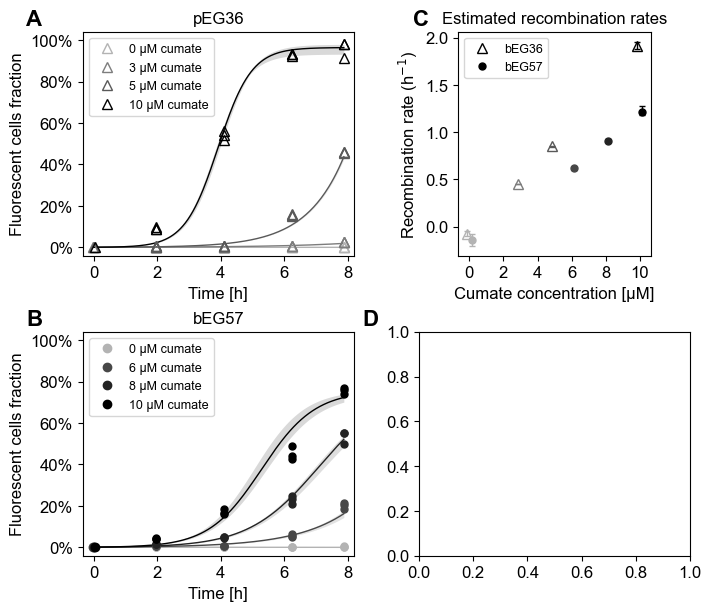

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick

plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12  # default size; adjust as needed
})

# ---------- shared grayscale mapper ----------
def conc_gray_color_map(concs, light=0.7, dark=0.0):
    """
    Return dict {conc: color} mapping each concentration to a gray color.
    light=0.7 (~light gray), dark=0.0 (black).
    Ensures the minimum conc maps to 'light' and the maximum to 'dark'.
    """
    concs_sorted = sorted(concs)
    min_c, max_c = concs_sorted[0], concs_sorted[-1]
    cmap = {}
    for c in concs_sorted:
        if max_c > min_c:
            norm = (c - min_c) / (max_c - min_c)   # 0..1
        else:
            norm = 1.0
        gray_val = light - norm * (light - dark)   # light -> dark
        cmap[c] = plt.cm.gray(gray_val)
    return cmap

# ---------- helper: average prediction per conc (no labels; color passed in) ----------
def add_avg_prediction_per_conc(ax, strain_name, bio_rep_label, color_map,
                                max_hours=MAX_HOURS):
    """
    For each concentration within (strain, bio_rep):
      - build the prediction y_i(t) from EACH technical replicate's fitted model
      - plot the mean curve
      - shade the MIN–MAX envelope across technical replicates (explicit)
    """
    sub = replicate_level_df[
        (replicate_level_df['strain'] == strain_name) &
        (replicate_level_df['biological_replicate'] == bio_rep_label)
    ]
    if sub.empty:
        return

    for conc, grp in sub.groupby('concentration'):
        # time span for this bio-rep × conc (capped at max_hours)
        mask_time = (
            (df_all['strain_name'] == strain_name) &
            (df_all['biological_replicate'] == bio_rep_label) &
            (df_all['Inducer_concentration [uM]'] == conc) &
            (df_all['time_point [min]'] <= max_hours * 60)
        )
        tmax_min = df_all.loc[mask_time, 'time_point [min]'].max()
        if not np.isfinite(tmax_min) or tmax_min <= 0:
            continue

        t_fit = np.linspace(0.0, min(max_hours, tmax_min / 60.0), 200)

        preds = []
        for _, row in grp.iterrows():
            if row['best_model'] == 'full':
                # If your DataFrame uses a different column name for fmax, adjust here:
                fmax_val = row['fmax_mcmc']  # e.g., use MLE; or 'fmax_mcmc' in older outputs
                y = 100.0 * full_model(t_fit, fmax_val, row['k_best'], row['f0'])
            else:
                y = 100.0 * exp_model(t_fit, row['k_best'], row['f0'])
            preds.append(y)

        if not preds:
            continue

        Y = np.vstack(preds)          # shape (n_tech=3, T)
        y_mean = Y.mean(axis=0)       # center line (or np.median(Y, axis=0))
        y_min  = Y.min(axis=0)        # ---- explicit MIN band
        y_max  = Y.max(axis=0)        # ---- explicit MAX band

        clr = color_map.get(conc, 'k')
        ax.plot(t_fit, y_mean, lw=1, color=clr)
        ax.fill_between(t_fit, y_min, y_max, alpha=0.15, linewidth=0, color=clr)


# =================== FIGURE ===================
fig, axes = plt.subplots(2, 2, figsize=(7,6), constrained_layout=True)

# ---------------- Top-left: bEG36, Biological Replicate 1 only ----------------
strain_tl = "bEG36"
bio_rep_tl = "br1"
ax_tl = axes[0, 0]

df_points_tl = df_all[
    (df_all['strain_name'] == strain_tl) &
    (df_all['biological_replicate'] == bio_rep_tl)
]

concs_tl = sorted(df_points_tl['Inducer_concentration [uM]'].unique())
tl_color_map = conc_gray_color_map(concs_tl, light=0.7, dark=0.0)

# curves in same colors; no labels (legend will be symbol-only)
add_avg_prediction_per_conc(ax_tl, strain_tl, bio_rep_tl, tl_color_map)

# scatter: triangles with grayscale by concentration (no error bars)
for (conc, tr), g in df_points_tl.groupby(['Inducer_concentration [uM]', 'technical_replicate']):
    tdata = g['time_point [min]'].values / 60.0
    ydata = g['fraction_fluorescent_cells'].values
    ax_tl.plot(
        tdata, 100*ydata,
        '^', markerfacecolor='none', markeredgecolor=tl_color_map[conc],
        color=tl_color_map[conc], ms=7
    )

# symbol-only legend for concentrations (triangles)
handles_tl = [
    Line2D([0], [0], marker='^', linestyle='None', color='none',
           markerfacecolor='none', markeredgecolor=tl_color_map[c],
           markersize=7, label=f'{c:g} µM cumate')
    for c in concs_tl
]

# --- add shared t=0 markers (one per concentration) ---
baseline_tl = df_all[
    (df_all['strain_name'] == strain_tl) &
    (df_all['biological_replicate'] == bio_rep_tl) &
    (df_all['time_point [min]'] == 0)
]
if not baseline_tl.empty:
    y0 = baseline_tl['fraction_fluorescent_cells'].mean()  # or .median()
    # small horizontal jitter in HOURS so markers are separable at x=0
    offs = np.linspace(-0.03, 0.03, len(concs_tl)) if len(concs_tl) > 1 else [0.0]
    for c, dx in zip(concs_tl, offs):
        ax_tl.plot(
            0.0 + dx, 100*y0,
            '^', markersize=7,
            markerfacecolor='none', markeredgecolor=tl_color_map[c],
            color=tl_color_map[c], zorder=5
        )
    ax_tl.margins(x=0.04)  # make sure jitter isn’t clipped

ax_tl.legend(handles=handles_tl, fontsize=9, loc='upper left')
ax_tl.set_title('pEG36', fontsize=12)
ax_tl.set_xlabel('Time [h]')
ax_tl.set_ylabel('Fluorescent cells fraction')
ax_tl.set_ylim(-4, 104)

# ---------------- Bottom-left: bEG57, Biological Replicate 1 only ----------------
strain_bl = "bEG57"
bio_rep_bl = "br1"
ax_bl = axes[1, 0]

df_points_bl = df_all[
    (df_all['strain_name'] == strain_bl) &
    (df_all['biological_replicate'] == bio_rep_bl)
]

concs_bl = sorted(df_points_bl['Inducer_concentration [uM]'].unique())
bl_color_map = conc_gray_color_map(concs_bl, light=0.7, dark=0.0)

# curves in same colors; no labels
add_avg_prediction_per_conc(ax_bl, strain_bl, bio_rep_bl, bl_color_map)

# scatter: circles with grayscale by concentration (no error bars)
for (conc, tr), g in df_points_bl.groupby(['Inducer_concentration [uM]', 'technical_replicate']):
    tdata = g['time_point [min]'].values / 60.0
    ydata = g['fraction_fluorescent_cells'].values
    ax_bl.plot(
        tdata, 100*ydata,
        'o', markerfacecolor=bl_color_map[conc], markeredgecolor=bl_color_map[conc],
        color=bl_color_map[conc], ms=5
    )

# symbol-only legend for concentrations (circles)
handles_bl = [
    Line2D([0], [0], marker='o', linestyle='None', color='none',
           markerfacecolor=bl_color_map[c], markeredgecolor=bl_color_map[c],
           markersize=6, label=f'{c:g} µM cumate')
    for c in concs_bl
]

# --- add shared t=0 markers (one per concentration) ---
baseline_bl = df_all[
    (df_all['strain_name'] == strain_bl) &
    (df_all['biological_replicate'] == bio_rep_bl) &
    (df_all['time_point [min]'] == 0)
]
if not baseline_bl.empty:
    y0 = baseline_bl['fraction_fluorescent_cells'].mean()  # or .median()
    offs = np.linspace(-0.03, 0.03, len(concs_bl)) if len(concs_bl) > 1 else [0.0]
    for c, dx in zip(concs_bl, offs):
        ax_bl.plot(
            0.0 + dx, 100*y0,
            'o', markersize=6,
            markerfacecolor=bl_color_map[c], markeredgecolor=bl_color_map[c],
            color=bl_color_map[c], zorder=5
        )
    ax_bl.margins(x=0.04)

ax_bl.legend(handles=handles_bl, fontsize=9)

ax_bl.set_title('bEG57', fontsize=12)
ax_bl.set_xlabel('Time [h]')
ax_bl.set_ylabel('Fluorescent cells fraction')
ax_bl.set_ylim(-4, 104)

# After plotting data
ax_tl.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_bl.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

# # ---------------- Top-right: br1 only — mean ± 95% t-CI across TECH replicates ----------------
# from scipy.stats import t

# ax_tr = axes[0, 1]
# bio_rep_to_show = 'br1'  # <- first biological replicate

# # Filter to the single bio replicate
# br_df = replicate_level_df[replicate_level_df['biological_replicate'] == bio_rep_to_show].copy()

# # Aggregate over TECHNICAL replicates: mean and SD of k_best (per strain × concentration)
# agg_br1 = (
#     br_df
#     .groupby(['strain', 'concentration'])
#     .agg(
#         k_mean=('k_best', 'mean'),
#         k_std =('k_best', 'std'),
#         n     =('k_best', 'count')
#     )
#     .reset_index()
# )

# # Handle small n robustly
# agg_br1['sem'] = agg_br1['k_std'] / np.sqrt(agg_br1['n'])
# # t critical; for n<=1, set err=0
# crit = t.ppf(0.975, np.maximum(agg_br1['n'] - 1, 1))
# agg_br1['err'] = np.where(agg_br1['n'] > 1, crit * agg_br1['sem'], 0.0)

# # Use SAME per-concentration colors as other panels
# all_concs = sorted(replicate_level_df['concentration'].unique())
# conc_color = conc_gray_color_map(all_concs, light=0.7, dark=0.0)

# marker_map = {'bEG36': '^', 'bEG57': 'o'}
# size_map   = {'bEG36': 7,   'bEG57': 5}
# offset = 0.15  # horizontal dodge

# for i, strain in enumerate(['bEG36', 'bEG57']):
#     sub = agg_br1[agg_br1['strain'] == strain].sort_values('concentration')
#     if sub.empty:
#         continue
#     x_shift = -offset if i == 0 else offset
#     for _, r in sub.iterrows():
#         x   = r['concentration'] + x_shift
#         y   = r['k_mean']
#         err = r['err']
#         clr = conc_color[r['concentration']]

#         ax_tr.errorbar(
#             x, y, yerr=err,
#             fmt=marker_map[strain],
#             markersize=size_map[strain],
#             markerfacecolor=('none' if strain == 'bEG36' else clr),  # triangles empty, circles filled
#             markeredgecolor=clr,
#             color=clr,           # line + errorbar color
#             elinewidth=1,
#             capsize=2
#         )

# -------- right panel: mean with MIN–MAX across TECH replicates --------
ax_tr = axes[0, 1]
bio_rep_to_show = 'br1'  # first biological replicate

# Filter to the single bio replicate
br_df = replicate_level_df[replicate_level_df['biological_replicate'] == bio_rep_to_show].copy()

# Aggregate over TECHNICAL replicates per strain × concentration
agg_br1 = (
    br_df
    .groupby(['strain', 'concentration'])
    .agg(
        k_mean=('k_best', 'mean'),   # center for the marker
        k_min =('k_best', 'min'),    # lower bound across tech reps
        k_max =('k_best', 'max'),    # upper bound across tech reps
        n     =('k_best', 'count')
    )
    .reset_index()
)

# Colors per concentration (same grayscale mapping)
all_concs = sorted(replicate_level_df['concentration'].unique())
conc_color = conc_gray_color_map(all_concs, light=0.7, dark=0.0)

marker_map = {'bEG36': '^', 'bEG57': 'o'}
size_map   = {'bEG36': 7,   'bEG57': 5}
offset = 0.15  # horizontal dodge

for i, strain in enumerate(['bEG36', 'bEG57']):
    sub = agg_br1[agg_br1['strain'] == strain].sort_values('concentration')
    if sub.empty:
        continue
    x_shift = -offset if i == 0 else offset
    for _, r in sub.iterrows():
        x   = r['concentration'] + x_shift
        y   = r['k_mean']        # marker at the mean
        # asymmetric yerr to span min–max around the center
        yerr_low  = max(0.0, y - r['k_min'])
        yerr_high = max(0.0, r['k_max'] - y)
        clr = conc_color[r['concentration']]

        ax_tr.errorbar(
            x, y, yerr=[[yerr_low], [yerr_high]],  # min–max envelope
            fmt=marker_map[strain],
            markersize=size_map[strain],
            markerfacecolor=('none' if strain == 'bEG36' else clr),  # triangles empty, circles filled
            markeredgecolor=clr,
            color=clr,
            elinewidth=1,
            capsize=2
        )

# Shape-only legend for strains
from matplotlib.lines import Line2D
handles = [
    Line2D([], [], marker='^', linestyle='None', markerfacecolor='none',
           markeredgecolor='black', markersize=7, label='bEG36'),
    Line2D([], [], marker='o', linestyle='None', markerfacecolor='black',
           markeredgecolor='black', markersize=5, label='bEG57')
]
ax_tr.legend(handles=handles, fontsize=9)
ax_tr.set_xticks([0, 2, 4, 6, 8, 10])

ax_tr.set_xlabel('Cumate concentration [µM]')
ax_tr.set_ylabel('Recombination rate (h$^{-1}$)')
ax_tr.set_title('Estimated recombination rates', fontsize=12)

labels = ['A', 'C', 'B', 'D']
positions = [(0, 1), (0, 1), (0, 1), (0, 1)]

for ax, label in zip(axes.flat, labels):
    ax.text(
        -0.15, 1.1, label, 
        transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='right'
    )

phys_ratio = 163.5 / 141    # height / width
ax_tr.set_box_aspect(phys_ratio)
# ax_br.set_aspect(target_ratio)

fig.savefig("recomb_rates_AG_nonlin_fit.pdf", format="pdf", bbox_inches="tight")

plt.show()

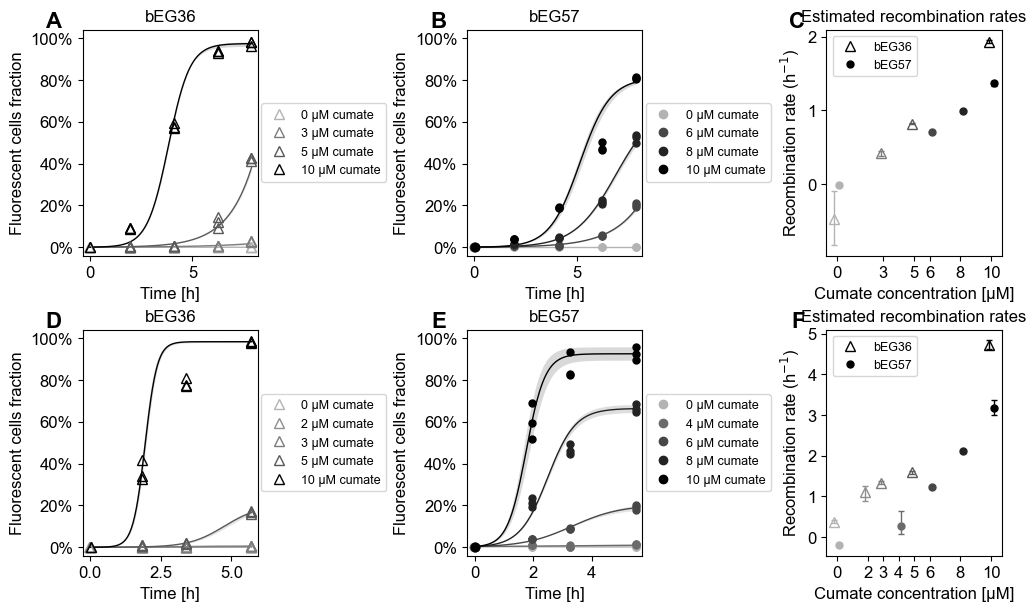

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from scipy.stats import t

MAX_HOURS = 10.0
MAX_MIN = int(MAX_HOURS * 60)


# ---------------- helper to draw one row (one bio rep): ----------------
def draw_row(ax_left, ax_mid, ax_right, bio_rep_label, strain_left="bEG36", strain_mid="bEG57"):
    # -------- left panel: strain_left --------
    df_points = df_all[
        (df_all['strain_name'] == strain_left) &
        (df_all['biological_replicate'] == bio_rep_label)
    ]
    # filter to <= 10 h
    df_points = df_points[df_points['time_point [min]'] <= MAX_MIN]

    concs = sorted(df_points['Inducer_concentration [uM]'].unique())
    color_map = conc_gray_color_map(concs, light=0.7, dark=0.0)

    add_avg_prediction_per_conc(ax_left, strain_left, bio_rep_label, color_map, max_hours=MAX_HOURS)

    # scatter (filtered already)
    for (conc, tr), g in df_points.groupby(['Inducer_concentration [uM]', 'technical_replicate']):
        
        tdata = g['time_point [min]'].values / 60.0
        ydata = g['fraction_fluorescent_cells'].values
        ax_left.plot(
            tdata, 100*ydata,
            '^', markerfacecolor='none', markeredgecolor=color_map[conc],
            color=color_map[conc], ms=7
        )

    handles_left = [
        Line2D([0], [0], marker='^', linestyle='None', color='none',
               markerfacecolor='none', markeredgecolor=color_map[c],
               markersize=7, label=f'{c:g} µM cumate')
        for c in concs
    ]

    # shared t=0 markers (no filter needed; t=0)
    baseline = df_all[
        (df_all['strain_name'] == strain_left) &
        (df_all['biological_replicate'] == bio_rep_label) &
        (df_all['time_point [min]'] == 0)
    ]
    if not baseline.empty and len(concs) > 0:
        y0 = baseline['fraction_fluorescent_cells'].mean()
        offs = np.linspace(-0.03, 0.03, len(concs)) if len(concs) > 1 else [0.0]
        for c, dx in zip(concs, offs):
            ax_left.plot(0.0 + dx, 100*y0, '^', markersize=7,
                         markerfacecolor='none', markeredgecolor=color_map[c],
                         color=color_map[c], zorder=5)
        ax_left.margins(x=0.04)

    ax_left.legend(
        handles=handles_left, fontsize=9,
        loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0
    )
    ax_left.set_title(strain_left, fontsize=12)
    ax_left.set_xlabel('Time [h]')
    ax_left.set_ylabel('Fluorescent cells fraction')
    # ax_left.set_xlim(0, MAX_HOURS)
    ax_left.set_ylim(-4, 104)
    ax_left.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    # -------- middle panel: strain_mid --------
    df_points_m = df_all[
        (df_all['strain_name'] == strain_mid) &
        (df_all['biological_replicate'] == bio_rep_label)
    ]
    df_points_m = df_points_m[df_points_m['time_point [min]'] <= MAX_MIN]

    concs_m = sorted(df_points_m['Inducer_concentration [uM]'].unique())
    color_map_m = conc_gray_color_map(concs_m, light=0.7, dark=0.0)

    add_avg_prediction_per_conc(ax_mid, strain_mid, bio_rep_label, color_map_m, max_hours=MAX_HOURS)

    for (conc, tr), g in df_points_m.groupby(['Inducer_concentration [uM]', 'technical_replicate']):
        tdata = g['time_point [min]'].values / 60.0
        ydata = g['fraction_fluorescent_cells'].values
        ax_mid.plot(
            tdata, 100*ydata,
            'o', markerfacecolor=color_map_m[conc], markeredgecolor=color_map_m[conc],
            color=color_map_m[conc], ms=5
        )

    handles_mid = [
        Line2D([0], [0], marker='o', linestyle='None', color='none',
               markerfacecolor=color_map_m[c], markeredgecolor=color_map_m[c],
               markersize=6, label=f'{c:g} µM cumate')
        for c in concs_m
    ]

    baseline_m = df_all[
        (df_all['strain_name'] == strain_mid) &
        (df_all['biological_replicate'] == bio_rep_label) &
        (df_all['time_point [min]'] == 0)
    ]
    if not baseline_m.empty and len(concs_m) > 0:
        y0m = baseline_m['fraction_fluorescent_cells'].mean()
        offs = np.linspace(-0.03, 0.03, len(concs_m)) if len(concs_m) > 1 else [0.0]
        for c, dx in zip(concs_m, offs):
            ax_mid.plot(0.0 + dx, 100*y0m, 'o', markersize=6,
                        markerfacecolor=color_map_m[c], markeredgecolor=color_map_m[c],
                        color=color_map_m[c], zorder=5)
        ax_mid.margins(x=0.04)

    ax_mid.legend(
        handles=handles_mid, fontsize=9,
        loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0
    )
    ax_mid.set_title(strain_mid, fontsize=12)
    ax_mid.set_xlabel('Time [h]')
    ax_mid.set_ylabel('Fluorescent cells fraction')
    ax_mid.set_ylim(-4, 104)
    # ax_mid.set_xlim(0, MAX_HOURS)
    ax_mid.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    # # -------- right panel: mean ± 95% t-CI across TECH replicates --------
    # br_df = replicate_level_df[replicate_level_df['biological_replicate'] == bio_rep_label].copy()
    # agg = (
    #     br_df
    #     .groupby(['strain', 'concentration'])
    #     .agg(k_mean=('k_best', 'mean'),
    #          k_std =('k_best', 'std'),
    #          n     =('k_best', 'count'))
    #     .reset_index()
    # )
    # agg['sem'] = agg['k_std'] / np.sqrt(agg['n'])
    # crit = t.ppf(0.975, np.maximum(agg['n'] - 1, 1))
    # agg['err'] = np.where(agg['n'] > 1, crit * agg['sem'], 0.0)

    # concs_row = sorted(agg['concentration'].unique())
    # conc_color = conc_gray_color_map(concs_row, light=0.7, dark=0.0)

    # marker_map = {strain_left: '^', strain_mid: 'o'}
    # size_map   = {strain_left: 7,   strain_mid: 5}
    # offset = 0.15

    # for i, strain in enumerate([strain_left, strain_mid]):
    #     sub = agg[agg['strain'] == strain].sort_values('concentration')
    #     if sub.empty:
    #         continue
    #     x_shift = -offset if i == 0 else offset
    #     for _, r in sub.iterrows():
    #         x   = r['concentration'] + x_shift
    #         y   = r['k_mean']
    #         err = r['err']
    #         clr = conc_color[r['concentration']]

    #         ax_right.errorbar(
    #             x, y, yerr=err,
    #             fmt=marker_map[strain],
    #             markersize=size_map[strain],
    #             markerfacecolor=('none' if strain == strain_left else clr),
    #             markeredgecolor=clr,
    #             color=clr,
    #             elinewidth=1,
    #             capsize=2
    #         )
    # -------- right panel: mean with MIN–MAX across TECH replicates --------
    br_df = replicate_level_df[replicate_level_df['biological_replicate'] == bio_rep_label].copy()
    
    # Aggregate over TECHNICAL replicates per strain × concentration
    agg = (
        br_df
        .groupby(['strain', 'concentration'])
        .agg(
            k_mean=('k_best', 'mean'),   # marker center
            k_min =('k_best', 'min'),    # lower bound across tech reps
            k_max =('k_best', 'max'),    # upper bound across tech reps
            n     =('k_best', 'count')
        )
        .reset_index()
    )
    
    # Colors per concentration (same grayscale mapping as other panels)
    concs_row = sorted(agg['concentration'].unique())
    conc_color = conc_gray_color_map(concs_row, light=0.7, dark=0.0)
    
    marker_map = {strain_left: '^', strain_mid: 'o'}
    size_map   = {strain_left: 7,   strain_mid: 5}
    offset = 0.15  # horizontal dodge
    
    for i, strain in enumerate([strain_left, strain_mid]):
        sub = agg[agg['strain'] == strain].sort_values('concentration')
        if sub.empty:
            continue
        x_shift = -offset if i == 0 else offset
        for _, r in sub.iterrows():
            x = r['concentration'] + x_shift
            y = r['k_mean']  # use median here if you prefer: compute k_median in agg and set y = r['k_median']
            # asymmetric error bars spanning min–max around the center
            yerr_low  = max(0.0, y - r['k_min'])
            yerr_high = max(0.0, r['k_max'] - y)
            clr = conc_color[r['concentration']]
    
            ax_right.errorbar(
                x, y, yerr=[[yerr_low], [yerr_high]],
                fmt=marker_map[strain],
                markersize=size_map[strain],
                markerfacecolor=('none' if strain == strain_left else clr),
                markeredgecolor=clr,
                color=clr,
                elinewidth=1,
                capsize=2
            )

    handles_shape = [
        Line2D([], [], marker='^', linestyle='None', markerfacecolor='none',
               markeredgecolor='black', markersize=7, label=strain_left),
        Line2D([], [], marker='o', linestyle='None', markerfacecolor='black',
               markeredgecolor='black', markersize=5, label=strain_mid)
    ]
    ax_right.legend(handles=handles_shape, fontsize=9)
    ax_right.set_xticks(sorted(concs_row))
    ax_right.set_xlabel('Cumate concentration [µM]')
    ax_right.set_ylabel('Recombination rate (h$^{-1}$)')
    ax_right.set_title('Estimated recombination rates', fontsize=12)

# ---------------- build the 2×3 figure for br2 (row 1) and br3 (row 2) ----------------
fig, axes = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)

# Row 1: br2
draw_row(axes[0,0], axes[0,1], axes[0,2], bio_rep_label='br2',
         strain_left='bEG36', strain_mid='bEG57')

# Row 2: br3
draw_row(axes[1,0], axes[1,1], axes[1,2], bio_rep_label='br3',
         strain_left='bEG36', strain_mid='bEG57')

# Panel letters A–F
panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']
for ax, lab in zip(axes.flat, panel_labels):
    ax.text(-0.12, 1.08, lab, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')

fig.savefig("six_panel_br2_br3.pdf", format="pdf", bbox_inches="tight")
plt.show()